# 스타일 전이 학습


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [ ]:
# 이미지 로드 함수(스타일 처리 전 처리/전처리)
def load_image(img_url, max_size=400):
  response = requests.get(img_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  size = max(image.size) if max(image.size) > max_size else max_size
  transform = transforms.Compose([
      transforms.Resize((size, size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return transform(image).unsqueeze(0)

In [ ]:
# 이미지 처리 함수 (스타일 처리 후 처리/ 후처리)
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach().squeeze()
  image = image.numpy().transpose(1, 2, 0)
  image = image * [0.229, 0.224, 0.225]
  image = image + [0.485, 0.456, 0.406]
  return image.clip(0, 1)

In [ ]:
# 이미지 URL
content_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"

In [ ]:
# 이미지 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content = load_image(content_url).to(device)
style = load_image(style_url, max_size=content.shape[-1]).to(device)

In [ ]:
# 모델 로드
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
  param.requires_grad_(False)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 특징 추출 함수
def get_features(image, model):
  layers = {
      '0':'conv1_1',
      '5':'conv2_1',
      '10':'conv3_1',
      '19':'conv4_1',
      '21':'conv4_2',
      '28':'conv5_1'
  }
  features = {}

  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x


  return features

In [ ]:
# 스타일 표현을 위한 행렬(채널 간 관계) 계산 함수
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  return torch.mm(tensor, tensor.t())

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {feature: gram_matrix(style_features[feature]) for feature in style_features}

target = content.clone().requires_grad_(True)
optim = torch.optim.Adam([target], lr=0.003)
style_weight = 1e4
content_weight = 1

In [ ]:
# 스타일 전이 학습
for i in range(200):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  style_loss = 0
  for i in style_grams:
    target_gram = gram_matrix(target_features[i])
    style_gram = style_grams[i]
    layer_loss = torch.mean((target_gram - style_gram)**2)
    style_loss += layer_loss/(target_features[i].shape[1]**2)

  total_loss = content_weight * content_loss + style_weight * style_loss
  optim.zero_grad()
  total_loss.backward()
  optim.step()

AttributeError: 'Tensor' object has no attribute 'datach'

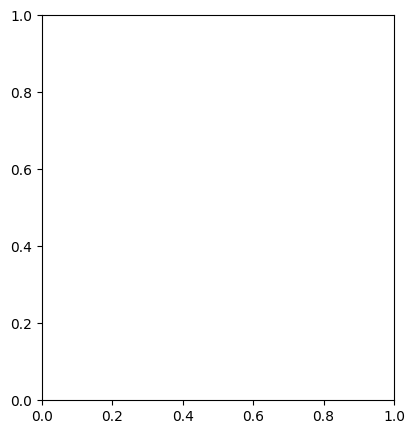

In [ ]:
# 결과 확인
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(im_convert(content))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(im_convert(target))
plt.title("transfer style")
plt.axis("off")
plt.show()

### [실습] 스타일 전이 학습
- 스타일 이미지 1장 + 콘텐츠 이미지 3장